### Preprocess Text
The text in the articles need to be preprocessed prior to analysis. The three primary components of preprocessing are:<br>

1. removing stop words
2. lemmatizing words (standardizing words to their root)
3. include part of speech tagging ("POS")

Eventually, we will be passing articles through a Word2Vec model which will generate word associations, by tagging the parts of speech right now, we will be able to identify which descriptors were most associted to a particular word or pronoun. This process is computationally very expensive since you are looping through each word of each article, and so we use Dask to parallelize the tasks

### Preprocess Text

In [1]:
import pandas as pd
import spacy
import dask.dataframe as dd
from dask.multiprocessing import get
from data_pull_helpers import preprocess_text

In [2]:
df = pd.read_json('/Users/surajravi/src/git/scrapy/tutorial/articles_87_99.json')

In [3]:
df.shape

(113158, 4)

## Read in all data, and merge articles into one dataframe

In [4]:
import sys
sys.path.append('/Users/surajravi/src/git')
from helpers.plot_wrappers import plt_histn

%matplotlib inline

In [5]:
for ii in df[df.article_text.str.len()<500].index[:5]:
    length = len(df.loc[ii,'article_text'])
    print(f'-----------article {ii} {length} characters-----------')
    print(df.loc[ii, 'article_text'])

-----------article 0 459 characters-----------
Wider Audience for Cuomo  Governor Cuomo, widely regarded as a possible Presidential candidate, said he would travel to five states in the next few months. Page 29.  Canadian Trade Anger  Canadian industry condemned an export tax being imposed to settle a dispute with the United States over lumber trade. Page 41.  Esquire Is Sold  Hearst has bought Esquire, the monthly magazine that has revived itself in recent years. The price was not announced. Page 43.
-----------article 28 161 characters-----------
Afghan Cease-Fire Plan  Afghanistan's Government announced that starting Jan. 15 it would observe a cease-fire, but guerrilla reaction seemed negative. Page A10.
-----------article 40 167 characters-----------
Penn State Is No. 1  Penn State halted a late Miami drive to win the Sunkist Fiesta Bowl, 14-10, and the unofficial national championship in college football. Page 41.
-----------article 53 189 characters-----------
The Istanbul Massac

In [6]:
df = (
    df[(df.title!='INSIDE')
       &(df.title!='Inside') #These are articles which just preview whats on the inside of the paper
       &(df.article_text.str.len()>500)]   #These are articles which are short summaries (see above)
    .reset_index(drop=True)
)

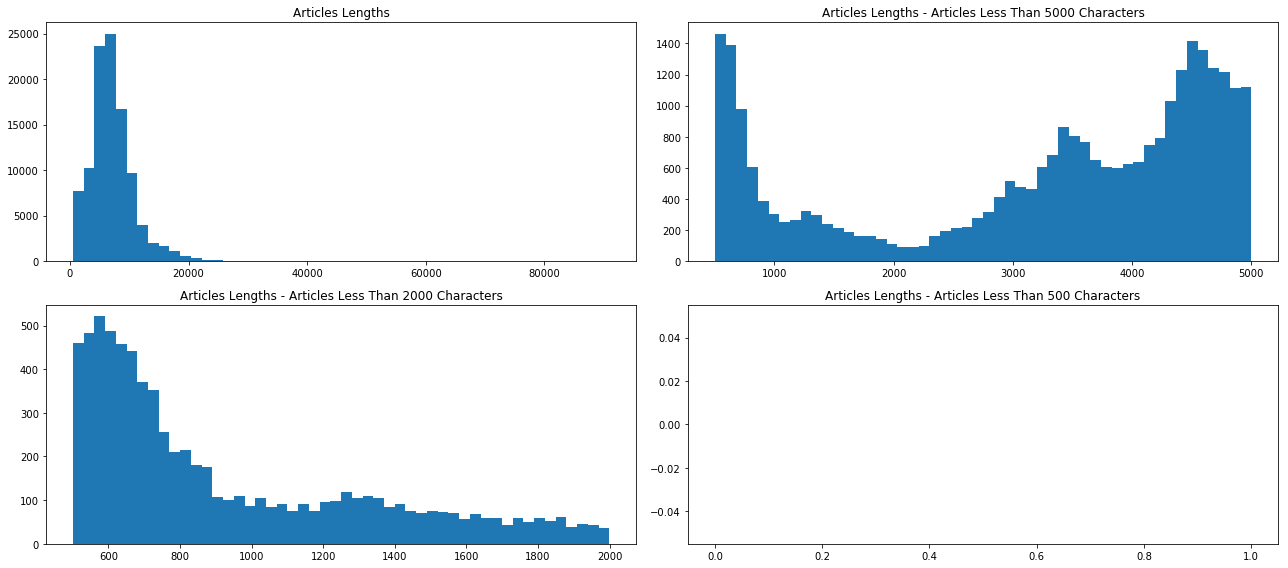

In [7]:
article_lengths = df.article_text.str.len()
plt_histn(article_lengths,
         'Articles Lengths', 
          article_lengths[article_lengths<5000],
         'Articles Lengths - Articles Less Than 5000 Characters',
          article_lengths[article_lengths<2000],
         'Articles Lengths - Articles Less Than 2000 Characters',
         article_lengths[article_lengths<500],
         'Articles Lengths - Articles Less Than 500 Characters',
          bins = 50
         )

## Preprocess

In [8]:
ddata = dd.from_pandas(df, npartitions=12)
def apply_myfunc_to_DF(df): return df['article_text'].apply(preprocess_text)
def dask_apply(ddata): return (ddata
                               .map_partitions(apply_myfunc_to_DF)
                               .compute(scheduler='processes'))
ddata['text_final'] = dask_apply(ddata)

In [9]:
ddata.to_parquet('data/articles_preprocessed_87_99.parquet', engine = 'pyarrow')

/anaconda3/envs/nlp/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)
